In [2]:
import pandas as pd
import numpy as np

In [3]:
# Load dataset
df = pd.read_csv('billboard_lyrics_1964-2015.csv', encoding = 'ISO-8859-1')

# Clean data
def clean_data(df):
    df = df.replace({'\n': ' '}, regex=True)
    df.dropna()
    df['word_count'] = df['Lyrics'].str.split().str.len()
    df = df[df['word_count'] != 1]
    df = df[df['word_count'] >= 100]
    df = df[df['word_count'] <= 1000] 
    df = df[df['Year'] >= 2015]
    return df

#Now this is good data...
df=clean_data(df)
df.head(5)

,Rank,Song,Artist,Year,Lyrics,Source,word_count
5000,1,uptown funk,mark ronson featuring bruno mars,2015,this hit that ice cold michelle pfeiffer that...,1.0,566.0
5001,2,thinking out loud,ed sheeran,2015,when your legs dont work like they used to be...,1.0,319.0
5002,3,see you again,wiz khalifa featuring charlie puth,2015,its been a long day without you my friend and...,1.0,486.0
5003,4,trap queen,fetty wap,2015,im like hey wassup hello seen yo pretty ass s...,1.0,550.0
5004,5,sugar,maroon 5,2015,im hurting baby im broken down i need your lo...,1.0,442.0


We now get the lyrics as a seperate dataframe and preprocess the text.

In [4]:
import spacy

# Import only relevant modules 
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

# Tokenization, stop word removal, and lemmatization.
def preprocess(text):
    doc = nlp(text)
    output = []
    for token in doc:
        if not token.is_stop and token.text:
            if token.text.isalpha() and len(token) > 2 and len(token) < 10:
                output.append(token.text)
    return output

# Preprocess lyrics
def preprocess_lyrics(df):
    documents=[]
    for row in df.itertuples():
        lyric=row[5]
        documents.append(preprocess(str(lyric)))
    return documents

# Get processed lyrics
hit_documents=preprocess_lyrics(df)

print(hit_documents[:3])

[['hit', 'ice', 'cold', 'michelle', 'pfeiffer', 'white', 'gold', 'hood', 'girls', 'good', 'girls', 'straight', 'stylin', 'whilen', 'livin', 'city', 'got', 'chucks', 'saint', 'laurent', 'got', 'kiss', 'prettyim', 'hot', 'hot', 'damn', 'called', 'police', 'fireman', 'hot', 'hot', 'damn', 'dragon', 'wanna', 'retire', 'man', 'hot', 'hot', 'damn', 'know', 'hot', 'hot', 'damn', 'bad', 'bout', 'money', 'break', 'downgirls', 'hit', 'whoo', 'girls', 'hit', 'whoo', 'girls', 'hit', 'whoo', 'cause', 'uptown', 'funk', 'gon', 'cause', 'uptown', 'funk', 'gon', 'cause', 'uptown', 'funk', 'gon', 'saturday', 'night', 'spot', 'believe', 'watch', 'come', 'ondont', 'believe', 'watch', 'uhdont', 'believe', 'watch', 'believe', 'watch', 'believe', 'watch', 'believe', 'watch', 'hey', 'hey', 'hey', 'meaning', 'byamandah', 'editor', 'girl', 'group', 'sequence', 'accused', 'bruno', 'mars', 'producer', 'mark', 'ronson', 'ripping', 'sound', 'uptown', 'funk', 'song', 'question', 'funk', 'stop', 'wait', 'minute', 'fi

We now visualize the dataset after cleaning:

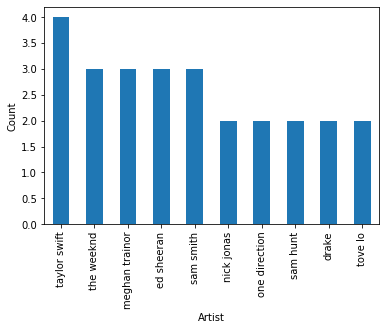

,Rank,Song,Artist,Year,Lyrics,Source,word_count
5073,74,dear future husband,meghan trainor,2015,dear future husband heres a few things youll ...,1.0,376.0
5085,86,ayo,chris brown and tyga,2015,i need you i need you i need you i need you i...,1.0,600.0
5069,70,no type,rae sremmurd,2015,yah bad bitches is the yahi aint got no type ...,1.0,436.0
5026,27,good for you,selena gomez featuring aap rocky,2015,im on my 14 carats im 14 carat doing it up li...,1.0,467.0
5061,62,the heart wants what it wants,selena gomez,2015,intro in the youtube video clip when i was on ...,3.0,360.0
5093,94,here,alessia cara,2015,i guess right now youve got the last laughim ...,1.0,465.0
5079,80,bang bang,jessie j ariana grande and nicki minaj,2015,verse 1 jessie j she got a body like an hourgl...,3.0,380.0
5068,69,all eyes on you,meek mill featuring chris brown and nicki minaj,2015,baby is you drunk is you had enough are you h...,1.0,425.0
5087,88,blessings,big sean featuring drake,2015,look i feel blessed way up i feel blessed way...,1.0,881.0
5059,60,uma thurman,fall out boy,2015,i can move mountains i can work a miracle wor...,1.0,315.0


In [6]:
import matplotlib.pyplot as plt

# Check distribution and dataframe structure
artist_count = df['Artist'].value_counts().head(10)
artist_count.plot.bar()
plt.xlabel('Artist')
plt.ylabel('Count')
plt.show()

df.sample(n=10)

Then, write code to train an [LdaModel] for $k=10$ topics, and using default values for all other parameters.
This is the topic model that each of the songs will need to be compared against.

In [7]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary

#Set number of topics
n=10

# Create a dictionary representation of the documents.
dictionary = Dictionary(hit_documents)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
hit_corpus = [dictionary.doc2bow(doc) for doc in hit_documents]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(hit_corpus))

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary. dont work w/o it temp is black magic
id2word = dictionary.id2token

# Create LDA topic model
hit_model = LdaModel(
    corpus=hit_corpus,
    id2word=id2word,
    num_topics=n
    )

hit_model.print_topics()

Number of unique tokens: 28
Number of documents: 98


[(0,
  '0.139*"need" + 0.134*"right" + 0.111*"come" + 0.106*"wanna" + 0.078*"baby" + 0.050*"ill" + 0.048*"good" + 0.047*"yeah" + 0.047*"life" + 0.046*"heart"'),
 (1,
  '0.351*"money" + 0.146*"wanna" + 0.086*"girl" + 0.046*"way" + 0.045*"yeah" + 0.035*"want" + 0.032*"home" + 0.031*"baby" + 0.029*"gon" + 0.024*"come"'),
 (2,
  '0.108*"baby" + 0.093*"wanna" + 0.087*"man" + 0.075*"right" + 0.070*"life" + 0.066*"ill" + 0.056*"tell" + 0.042*"good" + 0.038*"let" + 0.038*"stay"'),
 (3,
  '0.141*"gon" + 0.138*"wanna" + 0.133*"night" + 0.077*"need" + 0.060*"ill" + 0.053*"come" + 0.051*"song" + 0.046*"baby" + 0.041*"want" + 0.033*"tell"'),
 (4,
  '0.202*"baby" + 0.099*"think" + 0.097*"man" + 0.087*"gon" + 0.054*"yeah" + 0.050*"look" + 0.043*"let" + 0.042*"come" + 0.042*"tell" + 0.035*"heart"'),
 (5,
  '0.110*"song" + 0.106*"heart" + 0.087*"ill" + 0.064*"time" + 0.056*"home" + 0.054*"yeah" + 0.049*"life" + 0.046*"want" + 0.045*"right" + 0.045*"come"'),
 (6,
  '0.136*"night" + 0.119*"said" + 0.081*

Compare topic models for all songs lyrics. Wasserstein distance is used to calculate "hit-score" for each song. It is also possible to use hellinger distance.

In [8]:
from scipy.stats import wasserstein_distance
from gensim.matutils import hellinger

# Vectorize topics from the model
topic_vecs = []
for hit in hit_corpus:
    hit_topics = hit_model.get_document_topics(hit, minimum_probability=0.0)
    topic_vec = [hit_topics[i][1] for i in range(n)]
    topic_vecs.append(topic_vec)

# Calculates distance based on topic distribution for each song 
# based on cosine or Wasserstein similarity. Returns the n number
# of most similar hits based on distance between topic distributions
# between the documents.
def document_similarity(topic_vecs, n=10, dist = "w"):
    dists=[]
    i=0
    for x in topic_vecs:
        most_similar = 0.0
        j=0
        for y in topic_vecs:
            if dist == "h":
                similarity = 1-hellinger(x, y)
            elif dist == "w":
                similarity = 1-wasserstein_distance(x, y)
            
            if (similarity > most_similar and (i!=j)):
                most_similar=similarity
                doc1 = df.iat[i,1]
                doc2 = df.iat[j,1]
            j+=1
        dists.append((doc1, doc2, most_similar))
        i+=1
    sorted_dists = sorted(dists, key = lambda x: float(x[2]), reverse = True)
    return sorted_dists[0:n]

similar_songs = document_similarity(topic_vecs, n=20, dist = "w")

# Print the most similar song pairs and call our copyright lawyers!
for song_pair in similar_songs:
    print(song_pair)

('blank space', 'what do you mean', 0.9999999224208296)
('what do you mean', 'blank space', 0.9999999224208296)
('girl crush', 'like im gonna lose you', 0.9999997843056917)
('like im gonna lose you', 'girl crush', 0.9999997843056917)
('lean on', 'stay with me', 0.9999997754581272)
('stay with me', 'lean on', 0.9999997754581272)
('thinking out loud', 'marvin gaye', 0.9999997069127857)
('marvin gaye', 'thinking out loud', 0.9999997069127857)
('talking body', 'slow motion', 0.9999996981117875)
('slow motion', 'talking body', 0.9999996981117875)
('centuries', 'ghost', 0.9999996968079359)
('ghost', 'centuries', 0.9999996968079359)
('bad blood', 'heartbeat song', 0.999999648029916)
('heartbeat song', 'bad blood', 0.999999648029916)
('want to want me', 'style', 0.999999584746547)
('style', 'want to want me', 0.999999584746547)
('love me like you do', 'chains', 0.9999995163176209)
('chains', 'love me like you do', 0.9999995163176209)
('lips are movin', '711', 0.9999994232784957)
('711', 'lips 

The Wasserstein Similarity on topic distributions seem strange and is always very close to 1 for all
documents, we create distance measures with hellinger distance and Kullback–Leibler distance to evaluate
the results.

In [9]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Returns songs names for each song pair
def get_songs(song_pairs):
    song_names = []
    for pair in song_pairs:
        song1=pair[0]
        song2=pair[1]
        if [song2,song1] not in song_names:
            song_names+=[[song1, song2]]
    return song_names

# Get song names
songs = get_songs(similar_songs) 
    
# Returns songs lyrics from database             
def get_lyrics(songs, df):
    song_lyrics=[]
    for row in df.itertuples():
        name=row[2]
        lyric=row[5]
        if (name in songs):
            song_lyrics.append(str(lyric))
    return song_lyrics

# Calculates cosine similarity for text vectors
def cos_sim(texts): 
    vectors = [t for t in get_vectors(texts)]
    return cosine_similarity(vectors)

# Vectorize texts for lyrics
def get_vectors(strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

# Print Cosine similarity
for pair in songs:
    lyrics = get_lyrics(pair, df)  
    print(cos_sim(lyrics)[0][1])

0.5056043937393022
0.19945028981675153
0.23503257370614883
0.3461539690499301
0.3411720418290935
0.349449151500515
0.22874538375646053
0.2562342106727659
0.4856418441013462
0.19025342422750036


As we can see the documents have very low cosine similarity, which confirms the supicion that the approach of using Wasserstein similarity for topic distributions does not seem to yield similar documents....

Topic Analysis of hit songs done!